In [2]:
# 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using Pytorch version : {torch.__version__}, Device : {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10

Using Pytorch version : 1.8.1, Device : cpu


In [4]:
# FashionMNIST 데이터 다운로드 하기 (Train, Test set 분리)
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download= True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = False,
                                      transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

In [5]:
# 데이터 확인하기 (1)
for (X_train, y_train) in train_loader :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break

X_train : torch.Size([32, 1, 28, 28]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor


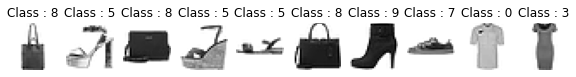

In [6]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class : {str(y_train[i].item())}')

In [7]:
# AutoEncoder(AE) 모델 설계하기
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
# Optimizer, Objective Function 설정하기
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [9]:
# AE 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [10]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad() :
        for image, _ in test_loader :
            image = image.view(-1,28*28).to(DEVICE)
            target = image.view(-1,28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, target).item()
            real_image.append(image.to('cpu'))
            gen_image.append(decoded.to('cpu'))
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch : 1 [0/60000(0%)]	Train Loss : 0.17799772322177887
Train Epoch : 1 [6400/60000(11%)]	Train Loss : 0.02924381196498871
Train Epoch : 1 [12800/60000(21%)]	Train Loss : 0.019701149314641953
Train Epoch : 1 [19200/60000(32%)]	Train Loss : 0.019200509414076805
Train Epoch : 1 [25600/60000(43%)]	Train Loss : 0.018969323486089706
Train Epoch : 1 [32000/60000(53%)]	Train Loss : 0.017716139554977417
Train Epoch : 1 [38400/60000(64%)]	Train Loss : 0.018322374671697617
Train Epoch : 1 [44800/60000(75%)]	Train Loss : 0.016235774382948875
Train Epoch : 1 [51200/60000(85%)]	Train Loss : 0.015889516100287437
Train Epoch : 1 [57600/60000(96%)]	Train Loss : 0.013880440033972263

[EPOCH:1] 	Test Loss : 0.0005



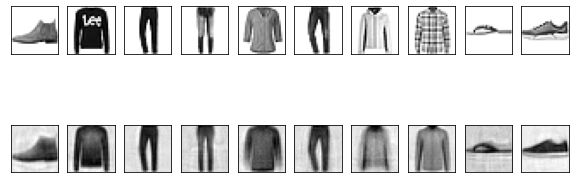

Train Epoch : 2 [0/60000(0%)]	Train Loss : 0.013934383168816566
Train Epoch : 2 [6400/60000(11%)]	Train Loss : 0.016987750306725502
Train Epoch : 2 [12800/60000(21%)]	Train Loss : 0.013332418166100979
Train Epoch : 2 [19200/60000(32%)]	Train Loss : 0.014995763078331947
Train Epoch : 2 [25600/60000(43%)]	Train Loss : 0.011048652231693268
Train Epoch : 2 [32000/60000(53%)]	Train Loss : 0.011759930290281773
Train Epoch : 2 [38400/60000(64%)]	Train Loss : 0.010880488902330399
Train Epoch : 2 [44800/60000(75%)]	Train Loss : 0.013039624318480492
Train Epoch : 2 [51200/60000(85%)]	Train Loss : 0.011514613404870033
Train Epoch : 2 [57600/60000(96%)]	Train Loss : 0.012555981986224651

[EPOCH:2] 	Test Loss : 0.0004



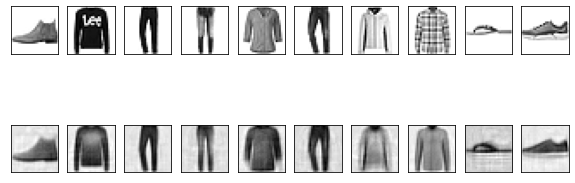

Train Epoch : 3 [0/60000(0%)]	Train Loss : 0.012942027300596237
Train Epoch : 3 [6400/60000(11%)]	Train Loss : 0.0107224490493536
Train Epoch : 3 [12800/60000(21%)]	Train Loss : 0.01272393949329853
Train Epoch : 3 [19200/60000(32%)]	Train Loss : 0.012248820625245571
Train Epoch : 3 [25600/60000(43%)]	Train Loss : 0.012032382190227509
Train Epoch : 3 [32000/60000(53%)]	Train Loss : 0.009679939597845078
Train Epoch : 3 [38400/60000(64%)]	Train Loss : 0.011909190565347672
Train Epoch : 3 [44800/60000(75%)]	Train Loss : 0.013727406971156597
Train Epoch : 3 [51200/60000(85%)]	Train Loss : 0.01232075598090887
Train Epoch : 3 [57600/60000(96%)]	Train Loss : 0.01172834262251854

[EPOCH:3] 	Test Loss : 0.0004



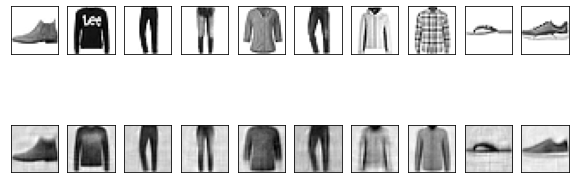

Train Epoch : 4 [0/60000(0%)]	Train Loss : 0.011376981623470783
Train Epoch : 4 [6400/60000(11%)]	Train Loss : 0.010160832665860653
Train Epoch : 4 [12800/60000(21%)]	Train Loss : 0.013561339117586613
Train Epoch : 4 [19200/60000(32%)]	Train Loss : 0.012633462436497211
Train Epoch : 4 [25600/60000(43%)]	Train Loss : 0.011851553805172443
Train Epoch : 4 [32000/60000(53%)]	Train Loss : 0.011549624614417553
Train Epoch : 4 [38400/60000(64%)]	Train Loss : 0.013227883726358414
Train Epoch : 4 [44800/60000(75%)]	Train Loss : 0.010517867282032967
Train Epoch : 4 [51200/60000(85%)]	Train Loss : 0.012360363267362118
Train Epoch : 4 [57600/60000(96%)]	Train Loss : 0.010202725417912006

[EPOCH:4] 	Test Loss : 0.0004



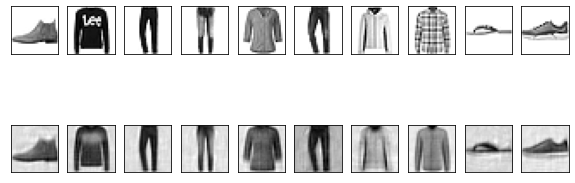

Train Epoch : 5 [0/60000(0%)]	Train Loss : 0.01034458912909031
Train Epoch : 5 [6400/60000(11%)]	Train Loss : 0.010436693206429482
Train Epoch : 5 [12800/60000(21%)]	Train Loss : 0.010886132717132568
Train Epoch : 5 [19200/60000(32%)]	Train Loss : 0.011959253810346127
Train Epoch : 5 [25600/60000(43%)]	Train Loss : 0.009794087149202824
Train Epoch : 5 [32000/60000(53%)]	Train Loss : 0.00977720133960247
Train Epoch : 5 [38400/60000(64%)]	Train Loss : 0.010720660910010338
Train Epoch : 5 [44800/60000(75%)]	Train Loss : 0.009126890450716019
Train Epoch : 5 [51200/60000(85%)]	Train Loss : 0.01141650602221489
Train Epoch : 5 [57600/60000(96%)]	Train Loss : 0.01194864884018898

[EPOCH:5] 	Test Loss : 0.0003



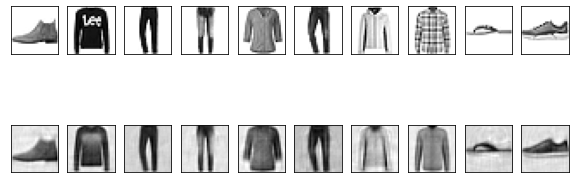

Train Epoch : 6 [0/60000(0%)]	Train Loss : 0.01087091863155365
Train Epoch : 6 [6400/60000(11%)]	Train Loss : 0.009726970456540585
Train Epoch : 6 [12800/60000(21%)]	Train Loss : 0.013042101636528969
Train Epoch : 6 [19200/60000(32%)]	Train Loss : 0.010348829440772533
Train Epoch : 6 [25600/60000(43%)]	Train Loss : 0.008942816406488419
Train Epoch : 6 [32000/60000(53%)]	Train Loss : 0.010204458609223366
Train Epoch : 6 [38400/60000(64%)]	Train Loss : 0.010465121828019619
Train Epoch : 6 [44800/60000(75%)]	Train Loss : 0.011433693580329418
Train Epoch : 6 [51200/60000(85%)]	Train Loss : 0.012823096476495266
Train Epoch : 6 [57600/60000(96%)]	Train Loss : 0.01075132004916668

[EPOCH:6] 	Test Loss : 0.0003



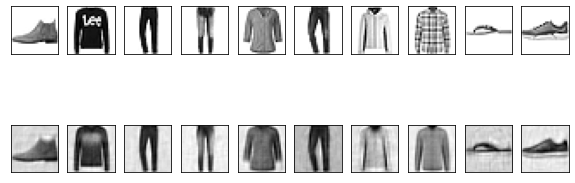

Train Epoch : 7 [0/60000(0%)]	Train Loss : 0.010562675073742867
Train Epoch : 7 [6400/60000(11%)]	Train Loss : 0.008207693696022034
Train Epoch : 7 [12800/60000(21%)]	Train Loss : 0.011458105407655239
Train Epoch : 7 [19200/60000(32%)]	Train Loss : 0.011218355968594551
Train Epoch : 7 [25600/60000(43%)]	Train Loss : 0.011095212772488594
Train Epoch : 7 [32000/60000(53%)]	Train Loss : 0.009450562298297882
Train Epoch : 7 [38400/60000(64%)]	Train Loss : 0.009225534275174141
Train Epoch : 7 [44800/60000(75%)]	Train Loss : 0.01032303273677826
Train Epoch : 7 [51200/60000(85%)]	Train Loss : 0.009998517110943794
Train Epoch : 7 [57600/60000(96%)]	Train Loss : 0.010591014288365841

[EPOCH:7] 	Test Loss : 0.0003



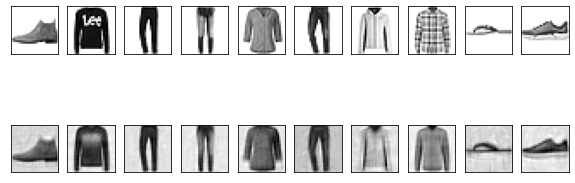

Train Epoch : 8 [0/60000(0%)]	Train Loss : 0.014155944809317589
Train Epoch : 8 [6400/60000(11%)]	Train Loss : 0.010408012196421623
Train Epoch : 8 [12800/60000(21%)]	Train Loss : 0.009234566241502762
Train Epoch : 8 [19200/60000(32%)]	Train Loss : 0.011579027399420738
Train Epoch : 8 [25600/60000(43%)]	Train Loss : 0.015394986607134342
Train Epoch : 8 [32000/60000(53%)]	Train Loss : 0.009644889272749424
Train Epoch : 8 [38400/60000(64%)]	Train Loss : 0.01355721615254879
Train Epoch : 8 [44800/60000(75%)]	Train Loss : 0.008432332426309586
Train Epoch : 8 [51200/60000(85%)]	Train Loss : 0.011053756810724735
Train Epoch : 8 [57600/60000(96%)]	Train Loss : 0.010601071640849113

[EPOCH:8] 	Test Loss : 0.0003



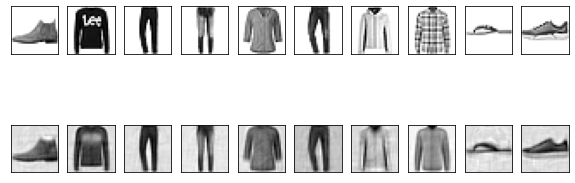

Train Epoch : 9 [0/60000(0%)]	Train Loss : 0.008640669286251068
Train Epoch : 9 [6400/60000(11%)]	Train Loss : 0.008190002292394638
Train Epoch : 9 [12800/60000(21%)]	Train Loss : 0.007771859411150217
Train Epoch : 9 [19200/60000(32%)]	Train Loss : 0.0095335952937603
Train Epoch : 9 [25600/60000(43%)]	Train Loss : 0.009550602175295353
Train Epoch : 9 [32000/60000(53%)]	Train Loss : 0.00993095338344574
Train Epoch : 9 [38400/60000(64%)]	Train Loss : 0.008941260166466236
Train Epoch : 9 [44800/60000(75%)]	Train Loss : 0.009716236032545567
Train Epoch : 9 [51200/60000(85%)]	Train Loss : 0.009063739329576492
Train Epoch : 9 [57600/60000(96%)]	Train Loss : 0.009472210891544819

[EPOCH:9] 	Test Loss : 0.0003



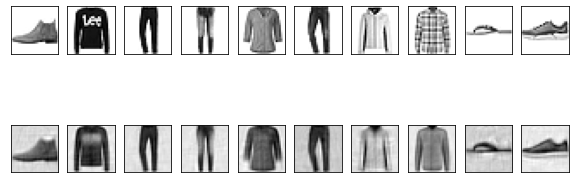

Train Epoch : 10 [0/60000(0%)]	Train Loss : 0.009659400209784508
Train Epoch : 10 [6400/60000(11%)]	Train Loss : 0.010821327567100525
Train Epoch : 10 [12800/60000(21%)]	Train Loss : 0.00816374272108078
Train Epoch : 10 [19200/60000(32%)]	Train Loss : 0.00867497455328703
Train Epoch : 10 [25600/60000(43%)]	Train Loss : 0.010571260936558247
Train Epoch : 10 [32000/60000(53%)]	Train Loss : 0.01126071996986866
Train Epoch : 10 [38400/60000(64%)]	Train Loss : 0.00844076368957758
Train Epoch : 10 [44800/60000(75%)]	Train Loss : 0.009580235928297043
Train Epoch : 10 [51200/60000(85%)]	Train Loss : 0.010538245551288128
Train Epoch : 10 [57600/60000(96%)]	Train Loss : 0.009627724066376686

[EPOCH:10] 	Test Loss : 0.0003



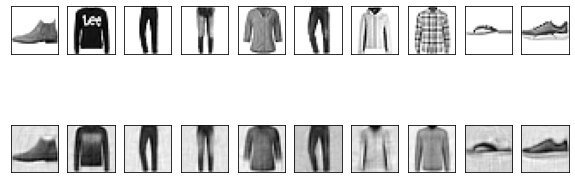

In [11]:
# AutoEncoder 학습을 실행하면서 Test set의 Reconstruction Error 확인
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200, epoch=Epoch)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f}\n")
    f, a = plt.subplots(2, 10, figsize=(10,4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap='gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28,28))
        a[1][i].imshow(img, cmap='gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()